## Human Fall Recognition Using Accelerometer Data

Dataset Link: https://sites.google.com/up.edu.mx/har-up/

or else google "Fall UP dataset"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import os
print(tf.__version__)

2.4.1


In [2]:
os.getcwd()

'C:\\Users\\Gaurav\\Downloads\\Accelerometer\\Testing Folder'

#### Load the Dataset 

In [3]:
### Enter file path here ###

path="C:/Users/Gaurav/Downloads/Accelerometer/Testing Folder/"

In [4]:
data=pd.read_csv(path+'accelall.csv')
# del data["Unnamed: 0"]
# data.head()

In [5]:
data.columns = ['user', 'label', 'time', 'x', 'y', 'z']
data.head()

,user,label,time,x,y,z
0,17,1,2018-07-12T11:54:19.944390,-0.914,-0.444,0.225
1,17,1,2018-07-12T11:54:19.990012,-0.914,-0.444,0.225
2,17,1,2018-07-12T11:54:20.041148,-0.917,-0.439,0.226
3,17,1,2018-07-12T11:54:20.084765,-0.917,-0.439,0.226
4,17,1,2018-07-12T11:54:20.144424,-0.916,-0.461,0.236


In [6]:
# Combining all fall cases as 1, non fall cases as 0
data['label'] = data['label'].map({1:1, 2:1, 3:1, 4:1, 5:1, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0})

In [7]:
data.shape

(884172, 6)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884172 entries, 0 to 884171
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   user    884172 non-null  int64  
 1   label   884034 non-null  float64
 2   time    884172 non-null  object 
 3   x       848063 non-null  float64
 4   y       848063 non-null  float64
 5   z       848063 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.5+ MB


In [9]:
#Handle Null values
data=data.dropna()

In [10]:
data.isnull().sum()

user     0
label    0
time     0
x        0
y        0
z        0
dtype: int64

In [11]:
data['label'].value_counts()

0.0    715582
1.0    132343
Name: label, dtype: int64

### Visualize Data

In [12]:
Fs = 10

In [13]:
activities = data['label'].value_counts().index

In [14]:
activities

Float64Index([0.0, 1.0], dtype='float64')

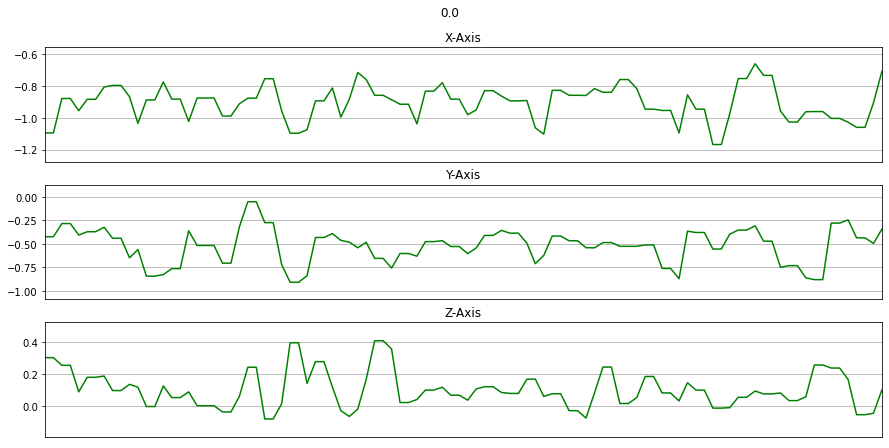

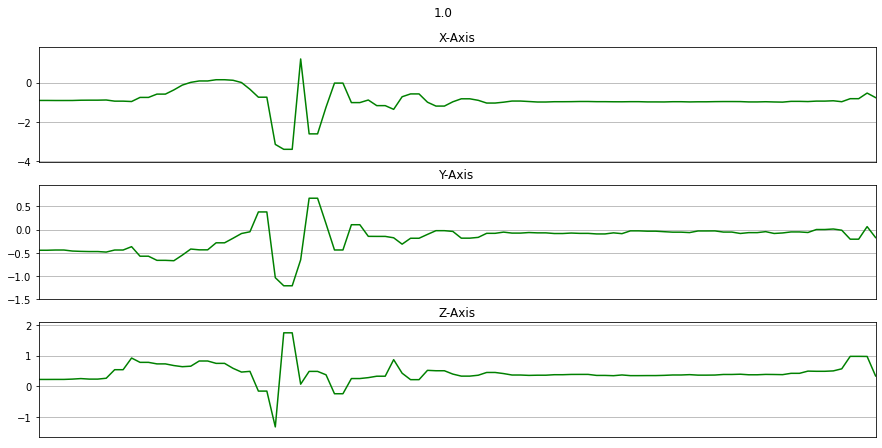

In [15]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data.index, data['x'], 'X-Axis')
    plot_axis(ax1, data.index, data['y'], 'Y-Axis')
    plot_axis(ax2, data.index, data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['label'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [16]:
# df = data.drop(['user', 'time'], axis = 1).copy()
# df.head()

### Balance this data 

In [17]:
count = min(data['label'].value_counts())
print(count)

132343


In [18]:
df=data.groupby('label').head(count).reset_index(drop=True)
print(df)

        user  label                        time      x      y      z
0         17    1.0  2018-07-12T11:54:19.944390 -0.914 -0.444  0.225
1         17    1.0  2018-07-12T11:54:19.990012 -0.914 -0.444  0.225
2         17    1.0  2018-07-12T11:54:20.041148 -0.917 -0.439  0.226
3         17    1.0  2018-07-12T11:54:20.084765 -0.917 -0.439  0.226
4         17    1.0  2018-07-12T11:54:20.144424 -0.916 -0.461  0.236
...      ...    ...                         ...    ...    ...    ...
264681     3    0.0  2018-07-05T12:12:36.589912 -0.153 -0.475  0.516
264682     3    0.0  2018-07-05T12:12:36.627512 -0.398 -1.028  0.723
264683     3    0.0  2018-07-05T12:12:36.679650 -0.398 -1.028  0.723
264684     3    0.0  2018-07-05T12:12:36.736426 -0.417 -1.061  0.706
264685     3    0.0  2018-07-05T12:12:36.784554 -0.411 -0.803  0.271

[264686 rows x 6 columns]


Table 5. Activities performed by subjects.
Activity ID Description Duration (s)

1. Falling forward using hands | 10
2. Falling forward using knees | 10
3. Falling backwards | 10
4. Falling sideward | 10 
5. Falling sitting in empty chair | 10
6. Walking | 60
7. Standing | 60
8. Sitting | 60
9. Picking up an object | 10
10. Jumping | 30
11. Laying | 60

In [19]:
df['label'].value_counts()

0.0    132343
1.0    132343
Name: label, dtype: int64

In [20]:
label = LabelEncoder()

df['label'] = label.fit_transform(df['label'])
df.head()

,user,label,time,x,y,z
0,17,1,2018-07-12T11:54:19.944390,-0.914,-0.444,0.225
1,17,1,2018-07-12T11:54:19.990012,-0.914,-0.444,0.225
2,17,1,2018-07-12T11:54:20.041148,-0.917,-0.439,0.226
3,17,1,2018-07-12T11:54:20.084765,-0.917,-0.439,0.226
4,17,1,2018-07-12T11:54:20.144424,-0.916,-0.461,0.236


In [60]:
label.classes_

array([0., 1.])

### Standardized data 

In [21]:
X = df[['x', 'y', 'z']]
y = df['label']

In [22]:
# scaler1 = StandardScaler()
# X = scaler1.fit_transform(X)

scaler2 = preprocessing.MaxAbsScaler()
X = scaler2.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.128461,-0.079627,0.024301,1
1,-0.128461,-0.079627,0.024301,1
2,-0.128883,-0.078730,0.024409,1
3,-0.128883,-0.078730,0.024409,1
4,-0.128742,-0.082676,0.025489,1
...,...,...,...,...
264681,-0.021504,-0.085187,0.055730,0
264682,-0.055938,-0.184362,0.078086,0
264683,-0.055938,-0.184362,0.078086,0
264684,-0.058609,-0.190280,0.076250,0


Wall time: 22 ms


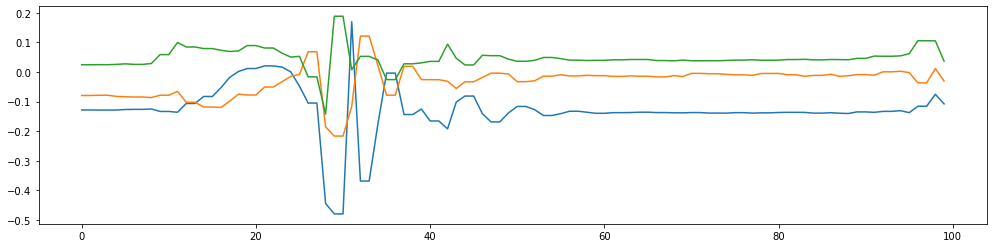

In [51]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 4))
plt.plot(scaled_X['x'][0:100])
plt.plot(scaled_X['y'][0:100])
plt.plot(scaled_X['z'][0:100])
#plt.plot(data['v*0.008'].values)
#plt.plot(data['g*0.016'].values)
#plt.plot(data['v*g'].values)

### Frame Preparation 

In [24]:
import scipy.stats as stats

In [25]:
frame_size = 16
hop_size = frame_size*1 # Subsetting into frames (As per frequency)

In [26]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [27]:
X, y = get_frames(df, frame_size, hop_size)

In [28]:
X.shape, y.shape

((16542, 16, 3), (16542,))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [30]:
X_train.shape, X_test.shape

((13233, 16, 3), (3309, 16, 3))

In [31]:
X_train[0].shape, X_test[0].shape

((16, 3), (16, 3))

In [32]:
a=X_train.shape
a = a + (1,)
b=X_test.shape
b = b + (1,)
print(a,b)

(13233, 16, 3, 1) (3309, 16, 3, 1)


In [33]:
X_train = X_train.reshape(a)
X_test = X_test.reshape(b)

In [34]:
X_train[0].shape, X_test[0].shape

((16, 3, 1), (16, 3, 1))

### LSTM Model

In [35]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.preprocessing import sequence
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

In [36]:
# model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(20, 3)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(100))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [37]:
# epoch=50
# history = model.fit(X_train,
#                     y_train,
#                     batch_size=64,
#                     epochs = epoch,
#                     validation_data = (X_test, y_test),
#                     verbose=1)

In [38]:
# plot_learningCurve(history, epoch)

### 2D CNN Model 

In [61]:
model = tf.keras.Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

#model.add(Dense(labels+1, activation='softmax'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 15, 2, 16)         80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 2, 16)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 2, 32)         2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 2, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 2, 32)         4128      
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 2, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)              

In [62]:
model.compile(optimizer=Adam(learning_rate = 0.0009), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [63]:
epoch=80
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
# , shuffle= "TRUE"
history = model.fit(X_train, y_train, batch_size=32, callbacks=[callback], epochs = epoch, validation_data= (X_test, y_test), verbose=1)

Epoch 1/80
414/414 [==============================] - 3s 6ms/step - loss: 0.5103 - accuracy: 0.7548 - val_loss: 0.4253 - val_accuracy: 0.8057
Epoch 2/80
414/414 [==============================] - 2s 6ms/step - loss: 0.4462 - accuracy: 0.7949 - val_loss: 0.4235 - val_accuracy: 0.8081
Epoch 3/80
414/414 [==============================] - 2s 6ms/step - loss: 0.4308 - accuracy: 0.8028 - val_loss: 0.4305 - val_accuracy: 0.8154
Epoch 4/80
414/414 [==============================] - 2s 5ms/step - loss: 0.4183 - accuracy: 0.8094 - val_loss: 0.4139 - val_accuracy: 0.8138
Epoch 5/80
414/414 [==============================] - 2s 6ms/step - loss: 0.4074 - accuracy: 0.8214 - val_loss: 0.3802 - val_accuracy: 0.8259
Epoch 6/80
414/414 [==============================] - 2s 6ms/step - loss: 0.3699 - accuracy: 0.8302 - val_loss: 0.3119 - val_accuracy: 0.8694
Epoch 7/80
414/414 [==============================] - 2s 6ms/step - loss: 0.2644 - accuracy: 0.9006 - val_loss: 0.1941 - val_accuracy: 0.9254
Epoch 

414/414 [==============================] - 2s 6ms/step - loss: 0.1664 - accuracy: 0.9401 - val_loss: 0.1480 - val_accuracy: 0.9471
Epoch 59/80
414/414 [==============================] - 2s 5ms/step - loss: 0.1606 - accuracy: 0.9427 - val_loss: 0.1333 - val_accuracy: 0.9547
Epoch 60/80
414/414 [==============================] - 2s 6ms/step - loss: 0.1720 - accuracy: 0.9391 - val_loss: 0.1501 - val_accuracy: 0.9468
Epoch 61/80
414/414 [==============================] - 2s 6ms/step - loss: 0.1544 - accuracy: 0.9484 - val_loss: 0.1351 - val_accuracy: 0.9565
Epoch 62/80
414/414 [==============================] - 2s 5ms/step - loss: 0.1652 - accuracy: 0.9399 - val_loss: 0.1464 - val_accuracy: 0.9474
Epoch 63/80
414/414 [==============================] - 2s 5ms/step - loss: 0.1602 - accuracy: 0.9463 - val_loss: 0.1337 - val_accuracy: 0.9550
Epoch 64/80
414/414 [==============================] - 2s 6ms/step - loss: 0.1659 - accuracy: 0.9437 - val_loss: 0.1483 - val_accuracy: 0.9498
Epoch 65/80

In [64]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

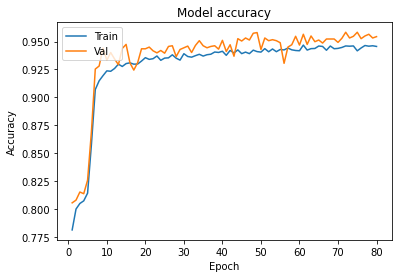

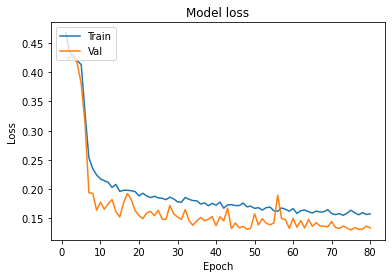

In [65]:
epoch=len(history.history['loss'])
plot_learningCurve(history, epoch)

### Confusion Matrix 

In [57]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [70]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(y_pred)
print(type(y_pred))

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]
<class 'numpy.ndarray'>


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

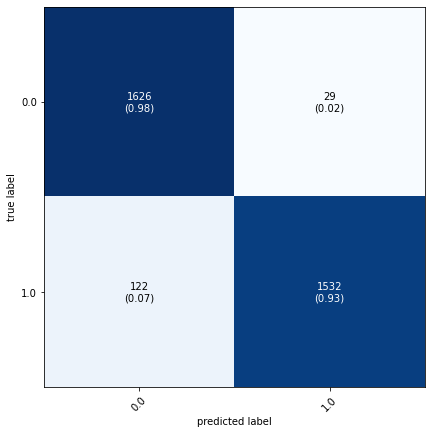

In [71]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7), class_names=label.classes_)

In [72]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(labels)]
print(classification_report(y_test, y_pred)) # target_names=label.classes_

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1655
           1       0.98      0.93      0.95      1654

    accuracy                           0.95      3309
   macro avg       0.96      0.95      0.95      3309
weighted avg       0.96      0.95      0.95      3309





*   The traditional Accuracy is a good measure if you have quite balanced datasets and are interested in all types of outputs equally.

*   Precision is great to focus on if you want to minimize false positives. For example, you build a spam email classifier. You want to see as little spam as possible. But you do not want to miss any important, non-spam emails. In such cases, you may wish to aim for maximizing precision.

*  Recall is very important in domains such as medical (e.g., identifying cancer), where you really want to minimize the chance of missing positive cases (predicting false negatives). These are typically cases where missing a positive case has a much bigger cost than wrongly classifying something as positive.


*  F1-score combines precision and recall, and works also for cases where the datasets are imbalanced as it requires both precision and recall to have a reasonable value, as demonstrated by the experiments I showed in this post. Even if you have a small number of positive cases vs negative cases, the formula will weight the metric value down if the precision or recall of the positive class is low.

In [49]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.9573815377533911

### Saving the Model

In [50]:
model.save('fall_detect_v3.model')
model.save('fall_detect_v3.h5')

INFO:tensorflow:Assets written to: fall_detect_v3.model\assets


In [ ]:
# import os
# # Fetch the Keras session and save the model
# # The signature definition is defined by the input and output tensors,
# # and stored with the default serving key
# import tempfile

# MODEL_DIR = tempfile.gettempdir()
# version = 1
# export_path = os.path.join(MODEL_DIR, str(version))
# print('export_path = {}\n'.format(export_path))

# tf.keras.models.save_model(
#     model,
#     export_path,
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None
# )

# print('\nSaved model:')

In [ ]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Convert the model.
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()

# Save the model.
#with open('model.tflite', 'wb') as f:
#  f.write(tflite_model)

In [ ]:
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV1 image classifier"
model_meta.description = ("Identify the most prominent object in the "
                          "image from a set of 1,001 categories such as "
                          "trees, animals, food, vehicles, person etc.")
model_meta.version = "v1"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

### Keras Tuner



In [ ]:
pip install keras-tuner

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(100, 3, 1)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 16-512
  
  hp_units = hp.Int('units', min_value = 16, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(64))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

##model = tf.keras.Sequential()
#model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
#model.add(Dropout(0.1))

#model.add(Conv2D(32, (2, 2), activation='relu'))
#model.add(Dropout(0.2))

#model.add(Flatten())

#model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(0.4))

#model.add(Dense(labels+1, activation='softmax'))

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(Conv2D(filters=hyperparam.Int('convolution_1',min_value=16, max_value=128, step=16), 
                   kernel_size=hyperparam.Choice('convolution_1', values = [2,6]), activation='relu',input_shape=X_train[0].shape)
  model.add(Conv2D(filters=hyperparam.Int('convolution_2', min_value=16, max_value=128, step=16), kernel_size = hyperparam.Choice('convolution_2', values = [2,6]), activation='relu'),
  model.add(Dropout(0.2))

  model.add(Flatten())

  model.add(Dense(64), activation = 'relu'))
  model.add(Dropout(0.4))

  model.add(Dense(labels+1, activation='softmax'))
  model.compile(optimizer=keras.optimizers.Adam(hyperparam.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                loss= keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics=['accuracy'])
  return model

In [ ]:
import kerastuner as kt
from tensorflow import keras
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [ ]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
tuner.search(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")